In [1]:
import math
import random
import numpy as np
import torch
import torchvision
import torchvision.transforms

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/MyDrive/APS360/datasets/raw"

pissarro_dataset  sisley_dataset


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import glob

sisley_path = "/content/gdrive/MyDrive/APS360/datasets/raw/sisley_dataset"
pissarro_path = "/content/gdrive/MyDrive/APS360/datasets/raw/pissarro_dataset"
pissarro_data = []
sisley_data = []
for filename in glob.glob(sisley_path+'/*.jpg'):
    img=Image.open(filename)
    sisley_data.append((img, filename))
for filename in glob.glob(pissarro_path+'/*.jpg'):
    img=Image.open(filename)
    pissarro_data.append((img, filename))
print("Number of sisley raw data: ", len(sisley_data))
print("Number of pissarro raw data: ", len(pissarro_data))

Number of sisley raw data:  801
Number of pissarro raw data:  1641


## Visualizing Some of the Raw Data

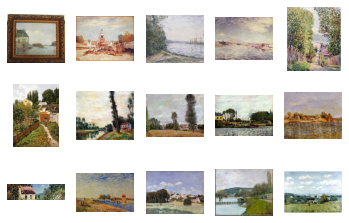

In [5]:
k = 0
for image, filename in sisley_data:
    
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(image)

    k += 1
    if k > 14:
        break

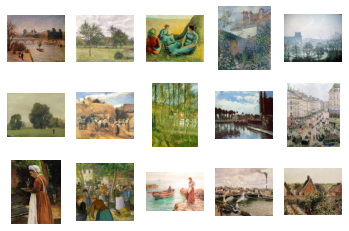

In [6]:
k = 0
for image, filename in pissarro_data:
    
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(image)

    k += 1
    if k > 14:
        break

##Helper functions to calculate color_metric

In [7]:
#https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/
def color_metric(image):
  # split the image into its respective RGB components
  (B, G, R) = (image[0], image[1], image[2])
  # compute rg = R - G
  rg = np.absolute(R - G)
  # compute yb = 0.5 * (R + G) - B
  yb = np.absolute(0.5 * (R + G) - B)
  # compute the mean and standard deviation of both `rg` and `yb`
  (rbMean, rbStd) = (rg.mean(), rg.std())
  (ybMean, ybStd) = (yb.mean(), yb.std())
  # combine the mean and standard deviations
  stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
  meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
  # derive the "colorfulness" metric and return it
  return stdRoot + (0.3 * meanRoot)

In [8]:
def get_fft(image):
  (fig, ax) = plt.subplots(1, 2, )
  img = torchvision.transforms.functional.rgb_to_grayscale(image)
  fft = torch.fft.fft2(img).squeeze()
  fftShift = torch.fft.fftshift(fft)
  magnitude = 20 * np.log(np.abs(fftShift))
  ax[0].imshow(np.transpose(image, [1,2,0]), cmap="gray")
  ax[1].imshow(magnitude, cmap="gray")
  
  fftShift[128][128] = 0
  fftShift = np.fft.ifftshift(fftShift)
  recon = np.fft.ifft2(fftShift)
  magnitude = 20 * np.log(np.abs(recon))
  mean = np.mean(magnitude)

Transform to 256x256px and center crop.

In [9]:
trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(256),
    torchvision.transforms.ToTensor(),
    ])
colorfull_range = []
num_colors_range = []
processed_sisley_data = []
processed_pissarro_data = []
for image, filename in sisley_data:
  image = trans(image)
  img = torchvision.transforms.functional.rgb_to_grayscale(image)
  colorfullness = color_metric(image)
  colorfull_range.append(colorfullness)
  num_colors = len(img.unique())
  num_colors_range.append(num_colors)
  processed_sisley_data.append((image, colorfullness, num_colors, filename))
for image, filename in pissarro_data:
  image = trans(image)
  if (image.shape[0] == 3):
    img = torchvision.transforms.functional.rgb_to_grayscale(image)
    colorfullness = color_metric(image)
  else:
    img = torch.tensor([0])
    colorfullness = 0
  colorfull_range.append(colorfullness)
  num_colors = len(img.unique())
  num_colors_range.append(num_colors)
  processed_pissarro_data.append((image, colorfullness, num_colors, filename))

## Seperate sketches with paintings

In [10]:
print("least 50% of color_metric: ", sorted(colorfull_range)[math.floor(len(sisley_data+pissarro_data)*0.5)])
print("least 5% of num_colors: ", sorted(num_colors_range)[math.floor(len(sisley_data+pissarro_data)*0.05)])

least 50% of color_metric:  tensor(0.1283)
least 5% of num_colors:  13304


In [11]:
clean_sisley_data = []
sketch_sisley_data = []
for image, colorfullness, num_colors, filename in processed_sisley_data:
  if colorfullness < 0.13 and num_colors < 14000: 
    sketch_sisley_data.append((image, filename))
  else: 
    clean_sisley_data.append((image, filename))

clean_pissarro_data = []
sketch_pissarro_data = []
for image, colorfullness, num_colors, filename in processed_pissarro_data:
  if colorfullness < 0.13 and num_colors < 14000: 
    sketch_pissarro_data.append((image, filename))
  else: 
    clean_pissarro_data.append((image, filename))

6


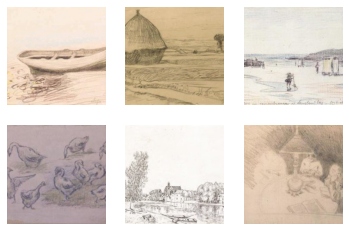

In [12]:
print(len(sketch_sisley_data))
k = 0
for image, filename in sketch_sisley_data:

    plt.subplot(2 ,3, k+1)
    plt.axis('off')
    plt.imshow(np.transpose(image, [1,2,0]))

    k += 1
    if k > 5:
        break

121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


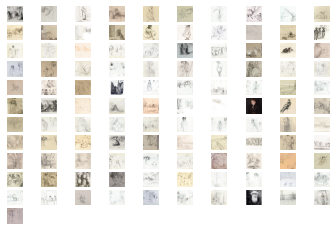

In [13]:
print(len(sketch_pissarro_data))
k = 0
for image, filename in sketch_pissarro_data:

    plt.subplot(12 ,10, k+1)
    plt.axis('off')
    if (image.shape[0] == 3):
      plt.imshow(np.transpose(image, [1,2,0]))

      k += 1
      if k > 119:
          break

795


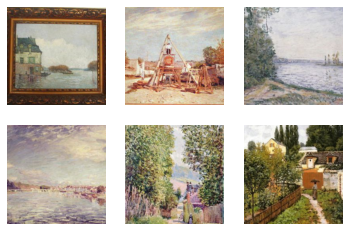

In [14]:
print(len(clean_sisley_data))
k = 0
for image, filename in clean_sisley_data:
    plt.subplot(2, 3, k+1)
    plt.axis('off')
    plt.imshow(np.transpose(image, [1,2,0]))

    k += 1
    if k > 5:
        break

1520


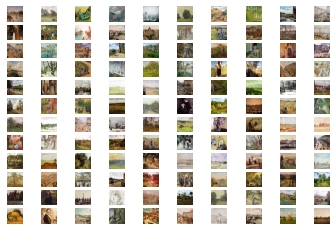

In [15]:
print(len(clean_pissarro_data))
k = 0
for image, filename in clean_pissarro_data:
    plt.subplot(12, 10, k+1)
    plt.axis('off')
    plt.imshow(np.transpose(image, [1,2,0]))

    k += 1
    if k > 119:
        break

##Let see the clean data, save them and split into train and test (90/10)

split index:  715


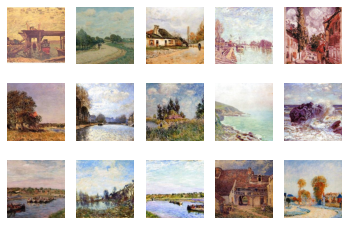

In [17]:
k = 0
for image, filename in clean_sisley_data:
      
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(np.transpose(image, [1,2,0]))

    k += 1
    if k > 14:
        break
random.shuffle(clean_sisley_data)
split = math.floor(len(clean_sisley_data)*0.9)
print("split index: ", split)
i = 0
for image, filename in clean_sisley_data:
    new_filename = filename.replace("/raw/", "/processed/")
    torchvision.utils.save_image(image, new_filename)
    if i < split:
      new_filename = filename.replace("raw/sisley_dataset", "sisley/trainA")
      marked_filename = filename.replace("raw/sisley_dataset/", "impressionism/trainA/sisley_")
    else:
      new_filename = filename.replace("raw/sisley_dataset", "sisley/testA")
      marked_filename = filename.replace("raw/sisley_dataset/", "impressionism/testA/sisley_")
    #torchvision.utils.save_image(image, new_filename)
    torchvision.utils.save_image(image, marked_filename)
    i += 1

split index:  1368


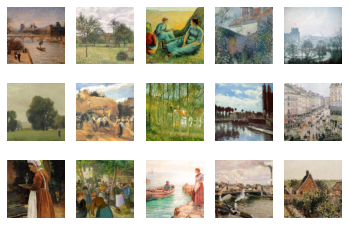

In [18]:
k = 0
for image, filename in clean_pissarro_data:
      
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(np.transpose(image, [1,2,0]))

    k += 1
    if k > 14:
        break
random.shuffle(clean_pissarro_data)
split = math.floor(len(clean_pissarro_data)*0.9)
print("split index: ", split)
i = 0
for image, filename in clean_pissarro_data:
    new_filename = filename.replace("/raw/", "/processed/")
    torchvision.utils.save_image(image, new_filename)
    if i < split:
      new_filename = filename.replace("raw/pissarro_dataset", "pissarro/trainA")
      marked_filename = filename.replace("raw/pissarro_dataset/", "impressionism/trainA/pissarro_")
    else:
      new_filename = filename.replace("raw/pissarro_dataset", "pissarro/testA")
      marked_filename = filename.replace("raw/pissarro_dataset/", "impressionism/testA/pissarro_")
    #torchvision.utils.save_image(image, new_filename)
    torchvision.utils.save_image(image, marked_filename)
    i += 1

In [19]:
sisley_path = "/content/gdrive/MyDrive/APS360/datasets/processed/sisley_dataset"
pissarro_path = "/content/gdrive/MyDrive/APS360/datasets/processed/pissarro_dataset"
all_data = []
for filename in glob.glob(sisley_path+'/*.jpg'):
    all_data.append(filename)
for filename in glob.glob(pissarro_path+'/*.jpg'):
    all_data.append(filename)
print("Number of all processed data: ", len(all_data))

Number of all processed data:  2315


In [20]:
sisley_path = "/content/gdrive/MyDrive/APS360/datasets/sisley"
pissarro_path = "/content/gdrive/MyDrive/APS360/datasets/pissarro"
impressionism_path = "/content/gdrive/MyDrive/APS360/datasets/impressionism"
sisley_train = []
sisley_test = []
pissarro_train = []
pissarro_test = []
all_train = []
all_test = []
for filename in glob.glob(sisley_path+'/trainA/*.jpg'):
    sisley_train.append(filename)
for filename in glob.glob(sisley_path+'/testA/*.jpg'):
    sisley_test.append(filename)
print("Number of train/test sisley data: ", len(sisley_train), ",", len(sisley_test))
for filename in glob.glob(pissarro_path+'/trainA/*.jpg'):
    pissarro_train.append(filename)
for filename in glob.glob(pissarro_path+'/testA/*.jpg'):
    pissarro_test.append(filename)
print("Number of train/test pissarro data: ", len(pissarro_train), ",", len(pissarro_test))

for filename in glob.glob(impressionism_path+'/trainA/*.jpg'):
    all_train.append(filename)
for filename in glob.glob(impressionism_path+'/testA/*.jpg'):
    all_test.append(filename)
print("Number of train/test all data: ", len(all_train), ",", len(all_test))

Number of train/test sisley data:  0 , 0
Number of train/test pissarro data:  0 , 0
Number of train/test all data:  2083 , 232
